In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports

import os
import sys
import time
import json
import copy
import cortex
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


sys.path.append("{}/../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface
from maths_utils import weighted_regression


In [2]:
# Import data base
main_dir = '/Users/uriel/disks/meso_shared'
# main_dir = '/home/ulascombes/disks/meso_shared'

project_dir = 'RetinoMaps'
suffix = 'Sac_Pur'

with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
rois = analysis_info['rois']
subjects = analysis_info['subjects']
TR = analysis_info['TR']
rois = analysis_info['rois']
ecc_threshold = analysis_info['ecc_th']
size_threshold = analysis_info['size_th']
rsqr_threshold = analysis_info['rsqr_th']
amplitude_threshold = analysis_info['amplitude_th']
stats_threshold = analysis_info['stats_th']
n_threshold = analysis_info['n_th']
prf_task_name = analysis_info['prf_task_name']
screen_size_cm = analysis_info['screen_size_cm']

In [3]:
# Plot settings
colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]


roi_colors_dict = {'V1': 'rgb(243, 231, 155)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}


In [4]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

# Participants 

In [28]:
participants_fn = '{}/{}/participants.tsv'.format(main_dir, project_dir)

In [29]:
participants = pd.read_table(participants_fn)

In [34]:
age_mean = participants['age'].mean()
age_min = participants['age'].min()
age_max = participants['age'].max()
n_female = participants.loc[participants['sex']=='F', 'sex'].count()
print('their is {} female participant mean age is {} age range is {}-{}'.format(n_female, age_mean, age_min, age_max))

their is 10 female participant mean age is 29.2 age range is 19-54


# pRF settings 

In [26]:
prf_events_fn = '{}/{}/sub-02/ses-01/func/sub-02_ses-01_task-pRF_run-01_events.tsv'.format(main_dir, project_dir)

In [27]:
prf_events = pd.read_table(prf_events_fn)

In [24]:
blanke_time = prf_events.loc[(prf_events['bar_direction'] == 9) & (prf_events['bar_period'] == 1), 'duration'].sum()
blanke_TR = prf_events.loc[(prf_events['bar_direction'] == 9) & (prf_events['bar_period'] == 1), 'duration'].count()


In [25]:
print('without stimulus time is {} ({} TRs)'.format(blanke_time.round(2), blanke_TR))

without stimulus time is 19.21 (16 TRs)


In [ ]:
# Compute bar step in DVA 



# Behaviour results

In [24]:
n_runs_prf = 5

for n_run in range(n_runs_prf):

    prf_events_fn = '{}/{}/sub-02/ses-01/func/sub-02_ses-01_task-pRF_run-0{}_events.tsv'.format(main_dir, project_dir, n_run+1)
    prf_events = pd.read_table(prf_events_fn)
    
    perf_run = np.zeros(prf_events.shape[0])
    stair_run = np.zeros(prf_events.shape[0])
    
    
    
    for t in np.arange(prf_events.shape[0]):
                    perf_run[t] = np.nanmean(prf_events.response_val[0:t])
                    stair_run[t] = np.nanmean(prf_events.stim_stair_val[0:t])
       
    if n_run==0: 
        perf_runs = perf_run
        stair_runs = stair_run
    else: 
        perf_runs = np.concatenate([perf_runs, perf_run])
        stair_runs = np.concatenate([stair_runs, stair_run])
                    
 
    
    
    

In [25]:
# Make DF 
# perf
perf_median = np.median(perf_runs[~np.isnan(perf_runs)])
perf_ci_low = np.quantile(perf_runs[~np.isnan(perf_runs)], 0.025)
perf_ci_up = np.quantile(perf_runs[~np.isnan(perf_runs)], 0.975)

# staircase
stair_median = np.median(stair_runs[~np.isnan(stair_runs)])
stair_ci_low = np.quantile(stair_runs[~np.isnan(stair_runs)], 0.025)
stair_ci_up = np.quantile(stair_runs[~np.isnan(stair_runs)], 0.975)

beh_df = pd.DataFrame()
beh_df['perf_median'] = [perf_median]
beh_df['perf_ci_low'] = [perf_ci_low]
beh_df['perf_ci_up'] = [perf_ci_up]

beh_df['stair_median'] = [stair_median]
beh_df['stair_ci_low'] = [stair_ci_low]
beh_df['stair_ci_up'] = [stair_ci_up]

In [26]:
beh_df

,perf_median,perf_ci_low,perf_ci_up,stair_median,stair_ci_low,stair_ci_up
0,0.8,0.730245,0.905411,6.666667,5.40625,9.756353


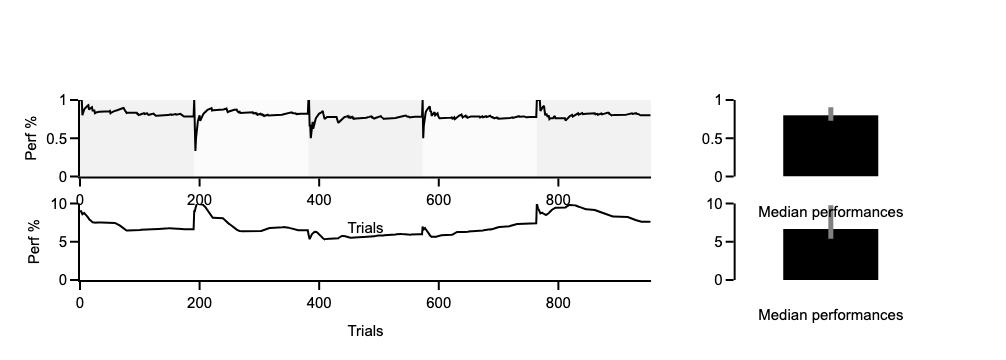

In [45]:
# Defind sublot 
fig = make_subplots(rows=2, cols=2, column_widths=[0.75, 0.25], print_grid=False)


# Perf 
# plot perf across trials 
fig.add_trace(go.Scatter(y=perf_runs[~np.isnan(perf_runs)], 
                         line=dict(color='black')), 
              row=1, col=1)

# make the bar plot 
fig.add_trace(go.Bar(y=beh_df.perf_median, 
                     marker=dict(color='black'),
                     error_y=dict(type='data', 
                                  symmetric=False, 
                                  array=beh_df.perf_ci_up - beh_df.perf_median, 
                                  arrayminus=beh_df.perf_median - beh_df.perf_ci_low, 
                                  thickness=5, 
                                  width=0,
                                  color='gray'), 
                     width=0.5),
              
              row=1, col=2)

# Staircase 
# plot perf across trials 
fig.add_trace(go.Scatter(y=stair_runs[~np.isnan(stair_runs)], 
                         line=dict(color='black')), 
              row=2, col=1)

# make the bar plot 
fig.add_trace(go.Bar(y=beh_df.stair_median, 
                     marker=dict(color='black'),
                     error_y=dict(type='data', 
                                  symmetric=False, 
                                  array=beh_df.stair_ci_up - beh_df.stair_median, 
                                  arrayminus=beh_df.stair_median - beh_df.stair_ci_low, 
                                  thickness=5, 
                                  width=0,
                                  color='gray'), 
                     width=0.5),
              
              row=2, col=2)



step = 191
x_max = len(perf_runs[~np.isnan(perf_runs)])  

for i in range(0, x_max, step):
    fig.add_shape(type="rect", 
                  x0=i, 
                  x1=i + step, 
                  y0=0, 
                  y1=1, 
                  fillcolor="gray" if (i // step) % 2 == 0 else "lightgray", 
                  opacity=0.1,
                  layer="below", 
                  line_width=0)
# perf 
fig.update_xaxes(showline=True, range=[0,x_max], title='Trials', row=1, col=1)
fig.update_yaxes(showline=True, range=[0,1], title='Perf %',row=1, col=1)

fig.update_xaxes(showline=False, ticks='', showticklabels=False, title='Median performances', row=1, col=2)
fig.update_yaxes(showline=True,range=[0,1],row=1, col=2)

# stair 
fig.update_xaxes(showline=True, range=[0,x_max], title='Trials', row=2, col=1)
fig.update_yaxes(showline=True, range=[0,10], title='Perf %', row=2, col=1)

fig.update_xaxes(showline=False, ticks='', showticklabels=False, title='Median performances', row=2, col=2)
fig.update_yaxes(showline=True,range=[0,10], row=2, col=2)


fig.update_layout(template=fig_template, showlegend=False)
fig.show()

In [44]:
[beh_df.perf_median]

[0    0.8
 Name: perf_median, dtype: float64]

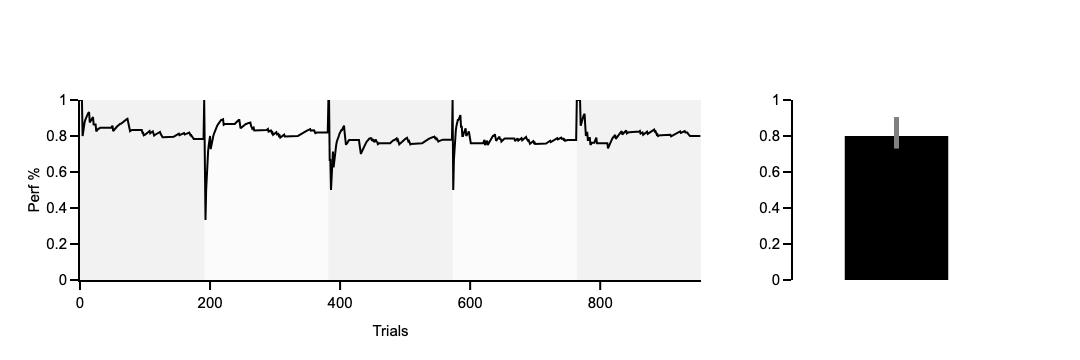

In [31]:
fig = make_subplots(rows=1, cols=2, column_widths=[0.75, 0.25], print_grid=False)


fig.add_trace(go.Scatter(y=perf_runs[~np.isnan(perf_runs)], 
                         line=dict(color='black')), 
              row=1, col=1)


perf_median = np.median(perf_runs[~np.isnan(perf_runs)])
ci_low = np.quantile(perf_runs[~np.isnan(perf_runs)], 0.025)
ci_up = np.quantile(perf_runs[~np.isnan(perf_runs)], 0.975)





fig.add_trace(go.Bar(#x=['attentional task performance'], 
                     y=[perf_median], 
                     marker=dict(color='black'),
                     error_y=dict(type='data', 
                                  symmetric=False, 
                                  array=[ci_up - perf_median], 
                                  arrayminus=[perf_median - ci_low], 
                                  thickness=5, 
                                  width=0,
                                  color='gray'), 
                     width=0.5),
              
              row=1, col=2)


step = 191
x_max = len(perf_runs[~np.isnan(perf_runs)])  

for i in range(0, x_max, step):
    fig.add_shape(type="rect", 
                  x0=i, 
                  x1=i + step, 
                  y0=0, 
                  y1=1, 
                  fillcolor="gray" if (i // step) % 2 == 0 else "lightgray", 
                  opacity=0.1,
                  layer="below", 
                  line_width=0)

fig.update_xaxes(showline=True, range=[0,x_max], title='Trials', row=1, col=1)
fig.update_yaxes(showline=True, range=[0,1], title='Perf %',row=1, col=1)

fig.update_xaxes(showline=False, visible=False, row=1, col=2)
fig.update_yaxes(showline=True,range=[0,1],row=1, col=2)
fig.update_layout(template=fig_template, showlegend=False)
fig.show()

In [1]:
import nibabel as nb

In [2]:
img = nb.load('/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/fmriprep/fmriprep/sub-01/ses-01/anat/sub-01_ses-01_hemi-L_midthickness.surf.gii')



In [3]:
img.darrays[0].meta['AnatomicalStructureSecondary']

'MidThickness'

In [4]:
img.darrays[0].meta['GeometricType']

'Anatomical'